In [1]:
from google.colab import drive 
drive.mount('/content/drive')
%cd /content/drive/MyDrive/cs395T/speechmodeltutorial/

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/MyDrive/cs395T/speechmodeltutorial


In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import torch
from tqdm.notebook import tqdm
from pytorchtools import EarlyStopping

import process


device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [4]:
X_train, X_test, Y_train, Y_test, mask = process.load_data(make_validation_set=False)

Doing lanczos interpolation with cutoff=0.499 and 3 lobes.
Doing lanczos interpolation with cutoff=0.499 and 3 lobes.
Doing lanczos interpolation with cutoff=0.499 and 3 lobes.
Doing lanczos interpolation with cutoff=0.499 and 3 lobes.
Doing lanczos interpolation with cutoff=0.499 and 3 lobes.
Doing lanczos interpolation with cutoff=0.499 and 3 lobes.
Doing lanczos interpolation with cutoff=0.499 and 3 lobes.
Doing lanczos interpolation with cutoff=0.499 and 3 lobes.
Doing lanczos interpolation with cutoff=0.499 and 3 lobes.
Doing lanczos interpolation with cutoff=0.499 and 3 lobes.
Doing lanczos interpolation with cutoff=0.499 and 3 lobes.


In [5]:
X_train = X_train.to(device)
Y_train = Y_train.to(device)
X_test = X_test.to(device)
Y_test = Y_test.to(device)

X_test = X_test.reshape(X_test.shape[0], 1, X_test.shape[1])

In [6]:
print(X_train.shape)
print(Y_train.shape)
print(type(X_train))
print(X_test.shape)
print(Y_test.shape)
from torch.autograd import Variable 

torch.Size([3737, 3072])
torch.Size([3737, 37226])
<class 'torch.Tensor'>
torch.Size([291, 1, 3072])
torch.Size([291, 37226])


In [7]:
class PCModel(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.d_out = Y_train.shape[-1] #number of classes
        self.num_layers = 1 #number of layers
        self.d_in = X_train.shape[-1] #input size
        self.hidden_size = 1024 #hidden state

        self.lstm = torch.nn.LSTM(input_size=self.d_in, hidden_size=self.hidden_size,
                          num_layers=self.num_layers, batch_first=True) #lstm
        self.fc_1 =  torch.nn.Linear(self.hidden_size, 1000) #fully connected 1
        self.fc_2 =  torch.nn.Linear(1000, 1000) #fully connected 1
        #self.dropout = torch.nn.Dropout(0.1)
        #self.maxpool = torch.nn.MaxPool1d(3, stride=2)
        self.fc = torch.nn.Linear(1000, self.d_out) #fully connected last layer

        self.relu = torch.nn.ReLU()
    
    def forward(self,x):
        h_0 = Variable(torch.zeros(self.num_layers, x.size(0), self.hidden_size)) #hidden state
        c_0 = Variable(torch.zeros(self.num_layers, x.size(0), self.hidden_size)) #internal state
        h_0 = h_0.cuda()
        c_0 = c_0.cuda()
        # h_1 = Variable(torch.zeros(self.num_layers, x.size(0), self.hidden_size)) #hidden state
        # c_1 = Variable(torch.zeros(self.num_layers, x.size(0), self.hidden_size)) #internal state
        # h_1 = h_1.cuda()
        # c_1 = c_1.cuda()
        #Propagate input through LSTM
        output, (hn, cn) = self.lstm(x, (h_0, c_0)) #lstm with input, hidden, and internal state
        hn = hn.view(-1, self.hidden_size) #reshaping the data for Dense layer next
        out1 = self.relu(hn)
        out1 = self.fc_1(out1) #first Dense
        out1 = self.relu(out1)
        out1 = self.fc_2(out1) #first Dense
        out1 = self.relu(out1) #relu
        out1 = self.fc(out1) #Final Output
        # output1, (hn1, cn1) = self.lstm(x, (h_1, c_1)) #lstm with input, hidden, and internal state
        # hn1 = hn1.view(-1, self.hidden_size) #reshaping the data for Dense layer next
        # out2 = self.relu(hn1)
        # out2 = self.fc_1(out2) #first Dense
        # out2 = self.relu(out2) #relu
        # out2 = self.fc(out2) #Final Output

        # out = out1 + out2

        return out1

In [19]:
model = PCModel().to(device)

print(model)


AKModel(
  (lstm): LSTM(3072, 1024, batch_first=True)
  (fc_1): Linear(in_features=1024, out_features=1000, bias=True)
  (fc_2): Linear(in_features=1000, out_features=1000, bias=True)
  (fc): Linear(in_features=1000, out_features=37226, bias=True)
  (relu): ReLU()
)


In [20]:
bs = 4000
all_idxs = range(len(X_train))


range(0, 3737)


In [21]:

opt = torch.optim.Adam(model.parameters(), lr=1e-3)

early_stopping = EarlyStopping(patience=20, verbose=True)


for epoch_idx in tqdm(range(1000)[:500]):
    all_batch_idxs = [all_idxs[i: i+bs] for i in range(0, len(all_idxs), bs)]
    valid_losses = []
    for batch_idxs in (all_batch_idxs):
        X_batch = X_train[batch_idxs]
        Y_batch = Y_train[batch_idxs]
        X_ray = X_batch.cpu().numpy()
        Y_ray = Y_batch.cpu().numpy()
        indices = np.arange(X_ray.shape[0])
        subindices = np.random.choice(indices, 100, replace = False)
        x_trn = np.delete(X_ray, subindices, 0)
        y_trn = np.delete(Y_ray, subindices, 0)
        x_val = np.take(X_ray, subindices, 0)
        y_val = np.take(Y_ray, subindices, 0)

        X_train_tensor = torch.tensor(x_trn).to(device)
        y_train_tensor = torch.tensor(y_trn).to(device)

        X_val_tensor = torch.tensor(x_val).to(device)
        y_val_tensor = torch.tensor(y_val).to(device)

        X_train_tensor = X_train_tensor.reshape(X_train_tensor.shape[0], 1, X_train_tensor.shape[1])
        Y_train_pred = model(X_train_tensor)
    
        loss = (y_train_tensor-Y_train_pred).pow(2).mean()
        
        X_val_tensor = X_val_tensor.reshape(X_val_tensor.shape[0], 1, X_val_tensor.shape[1])
        Y_val_pred = model(X_val_tensor)
        loss_val = (y_val_tensor-Y_val_pred).pow(2).mean()
        
        opt.zero_grad()
        loss.backward()
        opt.step()
        loss = loss.detach()
        valid_losses.append(loss_val.detach().cpu().numpy())

    valid_loss = np.average(valid_losses)
    valid_losses = [] 
    mse_train, corr_train = process.calc_stats(y_train_tensor.detach(), model(X_train_tensor).detach())
    mse_test, corr_test = process.calc_stats(Y_test.detach(), model(X_test).detach())
    if epoch_idx%5==0:
        process.show_stats(Y_test, model(X_test))
    early_stopping(valid_loss, model)
    if early_stopping.early_stop:
        print("Early stopping")
        break
model.load_state_dict(torch.load('checkpoint.pt'))

MSE:  1.0002776384353638
Mean Correlation:  0.0019327180925756693
Validation loss decreased (inf --> 0.984403).  Saving model ...
EarlyStopping counter: 1 out of 20
EarlyStopping counter: 2 out of 20
EarlyStopping counter: 3 out of 20
EarlyStopping counter: 4 out of 20
MSE:  1.0009456872940063
Mean Correlation:  0.023691123351454735
Validation loss decreased (0.984403 --> 0.944434).  Saving model ...
EarlyStopping counter: 1 out of 20
Validation loss decreased (0.944434 --> 0.943070).  Saving model ...
EarlyStopping counter: 1 out of 20
Validation loss decreased (0.943070 --> 0.941554).  Saving model ...
MSE:  1.0624821186065674
Mean Correlation:  0.019158270210027695
EarlyStopping counter: 1 out of 20
EarlyStopping counter: 2 out of 20
EarlyStopping counter: 3 out of 20
EarlyStopping counter: 4 out of 20
EarlyStopping counter: 5 out of 20
MSE:  1.0166431665420532
Mean Correlation:  0.02591979317367077
Validation loss decreased (0.941554 --> 0.930188).  Saving model ...
EarlyStopping c

<All keys matched successfully>

MSE:  1.0784119367599487
Mean Correlation:  0.0702541396021843


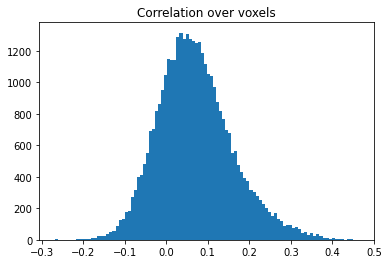

(1.0784119367599487, 0.0702541396021843)

In [22]:
process.show_stats(Y_test, model(X_test), show_vox_corr_hist=True)